Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script runs daily, reads in CSV files with a sorted order of homes (most attractive at the top to least attractive at the bottom), and a 'ypred' variable that reflects the scripts absolute metric (like P&L or probability of sale).

The script compares each list with homes that were sold, and identifies closed transactions ('positives') as well as the top 10 properties that each model identified that didn't sell ('negatives'). The remainder is considered 'control set'. 

For the overall data set, and specifically for each of those 3 groups, we output the average 'ypred' value, what number and percentage of homes sold from each.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

# how old a target list to compare to the current target list
lag_days = 40

pd.set_option('display.max_colwidth', -1)
discount = 0.050

# to remove all the random far away areas - PHX only
zipcode_list = ['85006', '85007', '85008', '85009', '85013', '85015', '85016', '85017',
       '85018', '85019', '85020', '85021', '85022', '85023', '85024',
       '85027', '85028', '85029', '85031', '85033', '85035', '85037',
       '85040', '85041', '85043', '85044', '85048', '85050', '85051',
       '85053', '85085', '85086', '85087', '85118', '85138', '85139',
       '85142', '85143', '85202', '85203', '85204', '85205', '85206',
       '85207', '85209', '85210', '85212', '85213', '85215', '85224',
       '85225', '85226', '85233', '85234', '85248', '85249', '85250',
       '85251', '85253', '85254', '85255', '85257', '85258', '85262',
       '85266', '85286', '85295', '85296', '85297', '85298', '85301',
       '85302', '85303', '85304', '85305', '85306', '85308', '85310',
       '85323', '85326', '85331', '85335', '85339', '85340', '85351',
       '85353', '85355', '85373', '85374', '85375', '85382', '85383',
       '85388', '85390', '85392', '85396', '85704', '85705', '85706',
       '85711', '85712']

In [2]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [3]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [4]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,14,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
closed.head()

,,price,transaction_status,date_listed,date_closed,days_on_market,transaction_type,is_latest,price_listed,price_closed,date_transacted_latest,...,school_district_id_57.0,school_district_id_60.0,school_district_id_67.0,school_district_id_68.0,school_district_id_75.0,school_district_id_87.0,school_district_id_90.0,school_district_id_93.0,school_district_id_96.0,school_district_id_nan
property_id,transaction_id,,,,,,,,,,,,,,,,,,,,,
967527,23814387,142500,closed,NaN,498,NaN,sales,False,NaN,142500,2001-05-13,...,0,0,0,0,0,0,0,0,0,0
9022260,23814307,122030,closed,NaN,-2018,NaN,sales,False,NaN,122030,1994-06-23,...,0,0,0,0,0,0,0,0,0,0
9022259,23814302,160000,closed,NaN,6459,NaN,sales,False,NaN,160000,2017-09-07,...,0,0,0,0,0,0,0,0,1,0
9022258,23814300,190450,closed,NaN,6442,NaN,sales,False,NaN,190450,2017-08-21,...,0,0,0,0,0,0,0,0,1,0
9022255,23814290,160000,closed,NaN,6421,NaN,sales,False,NaN,160000,2017-07-31,...,0,0,0,0,0,0,0,0,1,0


In [6]:
# read in prior target list for backtesting purposes
model_results = np.empty([0,7])
for lag_days in range(1,2):
    print("Lag days %i\n\n" % lag_days)
    try:
        prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                    .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                    .rename(columns = { 'ypred' : 'good_sell_prob'})

        backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
        backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
        y_all = prior_target_list.good_sell_prob.mean()
        y_sold = backtest.good_sell_prob.mean()

        pos_trigger = prior_target_list.good_sell_prob.quantile(0.75)
        slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
              % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

        num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
        positives = backtest[backtest.good_sell_prob > pos_trigger]
        y_pos = (-(positives.price - positives.list) / positives.list).median()
        num_sold = len(positives.index)
        if num_sold == 0:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tMed disc to list: NA" % (pos_trigger, num_pos) )    
        else:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tMed disc to list: %f" 
                  % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

        neg_trigger = prior_target_list.good_sell_prob.quantile(0.25)
        num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
        negatives = backtest[backtest.good_sell_prob < neg_trigger]
        y_neg = (-(negatives.price - negatives.list) / negatives.list).median()
        num_sold = len(negatives.index)

        if num_sold == 0:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tMedian disc to list: NA" % (neg_trigger, num_neg))
        else:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tMedian disc to list:%f" 
                  % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

        slack(backtest.to_string())
        backtest.to_csv("median_check.csv")
        # store results in arrays for graphing
        r = np.array([[lag_days, len(prior_target_list.index), len(backtest.index), num_sold / num_pos * 100, y_pos * 100, len(negatives.index) / num_neg * 100, y_neg * 100]])
        model_results = np.append(model_results,r,axis=0)
        
    except Exception as err:   
        print(err)

Lag days 1


Slacking: Prior target list length: 58	Num sold: 0	Avg good sell prob: 0.549824	Avg good sell prob of sold: nan
Slacking: Num of homes with good_sell_prob > 0.646753: 15	Perc of those sold: NONE	Med disc to list: NA
Slacking: Num of homes with good_sell_prob < 0.520407: 15	Perc of those sold: NONE	Median disc to list: NA
Slacking: Empty DataFrame
Columns: [address, zipcode, good_sell_prob, list, url, lat, long, date_listed, transaction_date, price, good_sell]
Index: []


In [7]:
import matplotlib.pyplot as plt
index = pd.Index(model_results[:,0], names='lag_days')
graph_results = pd.DataFrame(model_results[:,1:],index=index,columns=['num_for_sale', 'num_sold', 'perc_sold_good','discount_good', 'perc_sold_bad', 'discount_bad']) \
                    .sort_index(ascending=False)

graph_results.head()

,num_for_sale,num_sold,perc_sold_good,discount_good,perc_sold_bad,discount_bad
1.0,58.0,0.0,0.0,NaN,0.0,NaN


In [8]:
# graph_results[['num_for_sale', 'discount_good','discount_bad']].plot(figsize=(14,14),secondary_y='num_for_sale')

In [19]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = prior_target_list.pnl.quantile(0.75)
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = prior_target_list.pnl.quantile(0.25)

    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 1557	Num sold: 0	Avg P&L: 0.549824	Avg predict price: nan	Avg sale price: nan
Slacking: Num of homes with pnl > -85815.421875: 389	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Num of homes with pnl < -170188.156250: 389	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Empty DataFrame
Columns: [address, zipcode, pnl, predicted_price, list, url, price, good_sell]
Index: []


In [10]:
vb = pd.read_csv('value_buy/vb_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'pnl'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'good_sell_prob'}) \
       .drop_duplicates()
        
vb = vb[~vb.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of value buy\t%i" % len(vb.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([vb,gs],axis=1, join='inner')

c['pnl_percent'] = (c.pnl / c.list)

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of value buy	80
Len of good sell	58


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


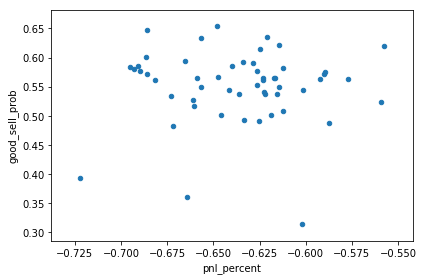

In [11]:
url = plot_rounds(c.query('good_sell_prob > 0.00').plot.scatter(x='pnl_percent', y='good_sell_prob'))
slack("", url, "Model Correlation")

In [12]:
# ran both data datasets and combine to create an equally weighted ensemble ranking
c["pnl_rank"] = c.pnl.rank(ascending=False)
c["gs_rank"] = c.good_sell_prob.rank(ascending=False)
c["rank"] = (c.pnl_rank + c.gs_rank)
c["zipcode"] = c.zipcode.apply(str)

# filter the output to remove duds
d = c[(c.pnl_percent > -0.2) & (c.good_sell_prob > 0.4) & (c.zipcode.isin(zipcode_list))]

In [13]:
d = c.sort_values("rank").nsmallest(20, "gs_rank")

file = csv_path + 'ensemble/comb_target_list_' + today.strftime('%Y%m%d') + '.csv'
np.round(d[['address', 'zipcode','list','predicted_price','pnl_percent','good_sell_prob','rank','url']], 4).to_csv(file)

slacker.files.upload(file, channels='#progress')

In [14]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

In [15]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [16]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

450214
8705 W Roanoke Ave, Phoenix, AZ 85037 
48
                                                            address      dist
property_id transaction_id                                                   
450214      22642480        8705 W Roanoke Ave, Phoenix, AZ 85037    0.000000
450692      23753402        8742 W Edgemont Ave, Phoenix, AZ 85037   0.134299
450587      23805027        8735 W Catalina Dr, Phoenix, AZ 85037    0.221668
441252      23796851        3001 N 86th Ln, Phoenix, AZ 85037        0.237022
520341      22734448        8921 W Edgemont Ave, Phoenix, AZ 85037   0.288054
9015638
8444 W Lewis Ave, Phoenix, AZ 85037 
48
                                                           address      dist
property_id transaction_id                                                  
9015638     22704145        8444 W Lewis Ave, Phoenix, AZ 85037     0.000000
448390      23757850        8403 W Lewis Ave, Phoenix, AZ 85037     0.067152
449589      23796595        8551 W Sheridan St, P

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



                                                            address      dist
property_id transaction_id                                                   
526828      22737450        9418 W Sheridan St, Phoenix, AZ 85037    0.000000
435965      23757849        2237 N 94th Ave, Phoenix, AZ 85037       0.059229
527635      22717844        9459 W Virginia Ave, Phoenix, AZ 85037   0.112527
525964      22488260        9307 W Bennet Plz, Phoenix, AZ 85037     0.286564
436097      23814104        2311 N 91st Gln, Phoenix, AZ 85037       0.288727
524237
9106 W Monte Vista Rd, Phoenix, AZ 85037 
48
                                                              address  \
property_id transaction_id                                              
524237      22678362        9106 W Monte Vista Rd, Phoenix, AZ 85037    
1859        23650472        9128 W Alvarado St, Phoenix, AZ 85037       
524898      23810672        9134 W Cypress St, Phoenix, AZ 85037        
524930      22304530        9134 W V

In [17]:
d

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
450214,22642480,-136049.898438,73950.101562,"8705 W Roanoke Ave, Phoenix, AZ 85037",85037,0.653611,210000,https://www.zillow.com/homedetails/8705-W-Roanoke-Ave-Phoenix-AZ-85037/7473636_zpid/,33.4784,-112.247,2017-09-08,2017-09-08,-0.647857,35.0,1.0,36.0
9015638,22704145,-121379.589844,55520.410156,"8444 W Lewis Ave, Phoenix, AZ 85037",85037,0.647865,176900,https://www.zillow.com/homedetails/8444-W-Lewis-Ave-Phoenix-AZ-85037/82823102_zpid/,33.4743,-112.241,2017-09-21,2017-09-21,-0.686148,19.0,2.0,21.0
444887,22730839,-133499.101562,81400.898438,"4607 N 92nd Ln, Phoenix, AZ 85037",85037,0.635422,214900,https://www.zillow.com/homedetails/4607-N-92nd-Ln-Phoenix-AZ-85037/7466411_zpid/,33.5044,-112.259,2017-09-28,2017-09-28,-0.621215,30.0,3.0,33.0
526828,22737450,-140851.406250,73648.593750,"9418 W Sheridan St, Phoenix, AZ 85037",85037,0.632807,214500,https://www.zillow.com/homedetails/9418-W-Sheridan-St-Phoenix-AZ-85037/67773035_zpid/,33.4750,-112.262,2017-09-28,2017-09-28,-0.656650,41.0,4.0,45.0
524237,22678362,-122220.500000,76779.500000,"9106 W Monte Vista Rd, Phoenix, AZ 85037",85037,0.621552,199000,https://www.zillow.com/homedetails/9106-W-Monte-Vista-Rd-Phoenix-AZ-85037/60047183_zpid/,33.4705,-112.256,2017-09-13,2017-09-13,-0.614173,20.0,5.0,25.0
527635,22717844,-111524.328125,88475.671875,"9459 W Virginia Ave, Phoenix, AZ 85037",85037,0.619680,200000,https://www.zillow.com/homedetails/9459-W-Virginia-Ave-Phoenix-AZ-85037/62727169_zpid/,33.4764,-112.263,2017-09-20,2017-09-20,-0.557622,6.0,6.0,12.0
520341,22734448,-124365.578125,74634.421875,"8921 W Edgemont Ave, Phoenix, AZ 85037",85037,0.614520,199000,https://www.zillow.com/homedetails/8921-W-Edgemont-Ave-Phoenix-AZ-85037/7487901_zpid/,33.4783,-112.252,2017-10-02,2017-10-02,-0.624953,23.0,7.0,30.0
441965,22659382,-113299.210938,51700.789062,"4022 N 88th Ln, Phoenix, AZ 85037",85037,0.601275,165000,https://www.zillow.com/homedetails/4022-N-88th-Ln-Phoenix-AZ-85037/7470881_zpid/,33.4932,-112.250,2017-09-09,2017-09-09,-0.686662,10.0,8.0,18.0
448390,23757850,-106450.640625,53549.359375,"8403 W Lewis Ave, Phoenix, AZ 85037",85037,0.594110,160000,https://www.zillow.com/homedetails/8403-W-Lewis-Ave-Phoenix-AZ-85037/81985441_zpid/,33.4738,-112.240,2017-10-19,2017-10-19,-0.665317,3.0,9.0,12.0


In [18]:
d.head()

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
450214,22642480,-136049.898438,73950.101562,"8705 W Roanoke Ave, Phoenix, AZ 85037",85037,0.653611,210000,https://www.zillow.com/homedetails/8705-W-Roanoke-Ave-Phoenix-AZ-85037/7473636_zpid/,33.4784,-112.247,2017-09-08,2017-09-08,-0.647857,35.0,1.0,36.0
9015638,22704145,-121379.589844,55520.410156,"8444 W Lewis Ave, Phoenix, AZ 85037",85037,0.647865,176900,https://www.zillow.com/homedetails/8444-W-Lewis-Ave-Phoenix-AZ-85037/82823102_zpid/,33.4743,-112.241,2017-09-21,2017-09-21,-0.686148,19.0,2.0,21.0
444887,22730839,-133499.101562,81400.898438,"4607 N 92nd Ln, Phoenix, AZ 85037",85037,0.635422,214900,https://www.zillow.com/homedetails/4607-N-92nd-Ln-Phoenix-AZ-85037/7466411_zpid/,33.5044,-112.259,2017-09-28,2017-09-28,-0.621215,30.0,3.0,33.0
526828,22737450,-140851.406250,73648.593750,"9418 W Sheridan St, Phoenix, AZ 85037",85037,0.632807,214500,https://www.zillow.com/homedetails/9418-W-Sheridan-St-Phoenix-AZ-85037/67773035_zpid/,33.4750,-112.262,2017-09-28,2017-09-28,-0.656650,41.0,4.0,45.0
524237,22678362,-122220.500000,76779.500000,"9106 W Monte Vista Rd, Phoenix, AZ 85037",85037,0.621552,199000,https://www.zillow.com/homedetails/9106-W-Monte-Vista-Rd-Phoenix-AZ-85037/60047183_zpid/,33.4705,-112.256,2017-09-13,2017-09-13,-0.614173,20.0,5.0,25.0
